In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import scipy
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import attila_utils
import gem_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ar = gem_tools.read_active_reactions(groupdict={'m-control': ('all_control', 'MSBB'), 'm-AD-B2': ('SubtypeB2_AD', 'MSBB')})

In [3]:
gemsubsys = gem_tools.read_gem_excel()['SUBSYSTEM']
gemsubsys

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


ID
MAR03905       Glycolysis / Gluconeogenesis
MAR03907       Glycolysis / Gluconeogenesis
MAR04097       Glycolysis / Gluconeogenesis
MAR04099       Glycolysis / Gluconeogenesis
MAR04108       Glycolysis / Gluconeogenesis
                         ...               
MAR10129             Bile acid biosynthesis
MAR10130             Bile acid biosynthesis
MAR10131             Bile acid biosynthesis
MAR10132          Exchange/demand reactions
MAR13083    Metabolism of other amino acids
Name: SUBSYSTEM, Length: 13069, dtype: object

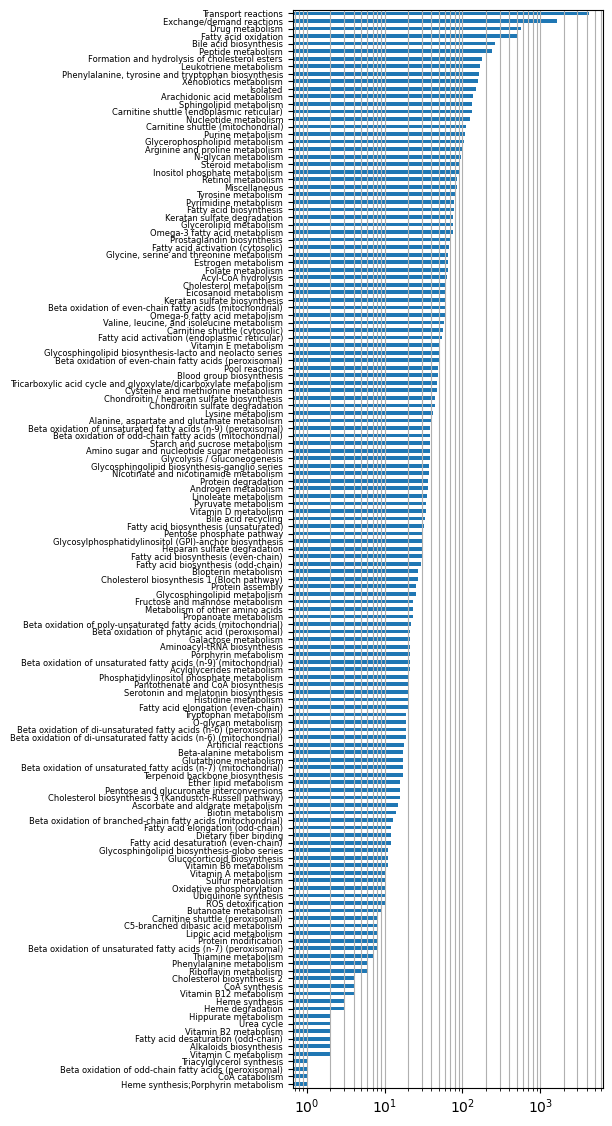

In [4]:
fig, ax = plt.subplots(figsize=(4, 14))
gemsubsys.value_counts(sort=True, ascending=True).plot(kind='barh')
ax.set_xscale('log')
ax.grid(axis='x', which='both')
ax.tick_params(axis='y', labelsize=6)

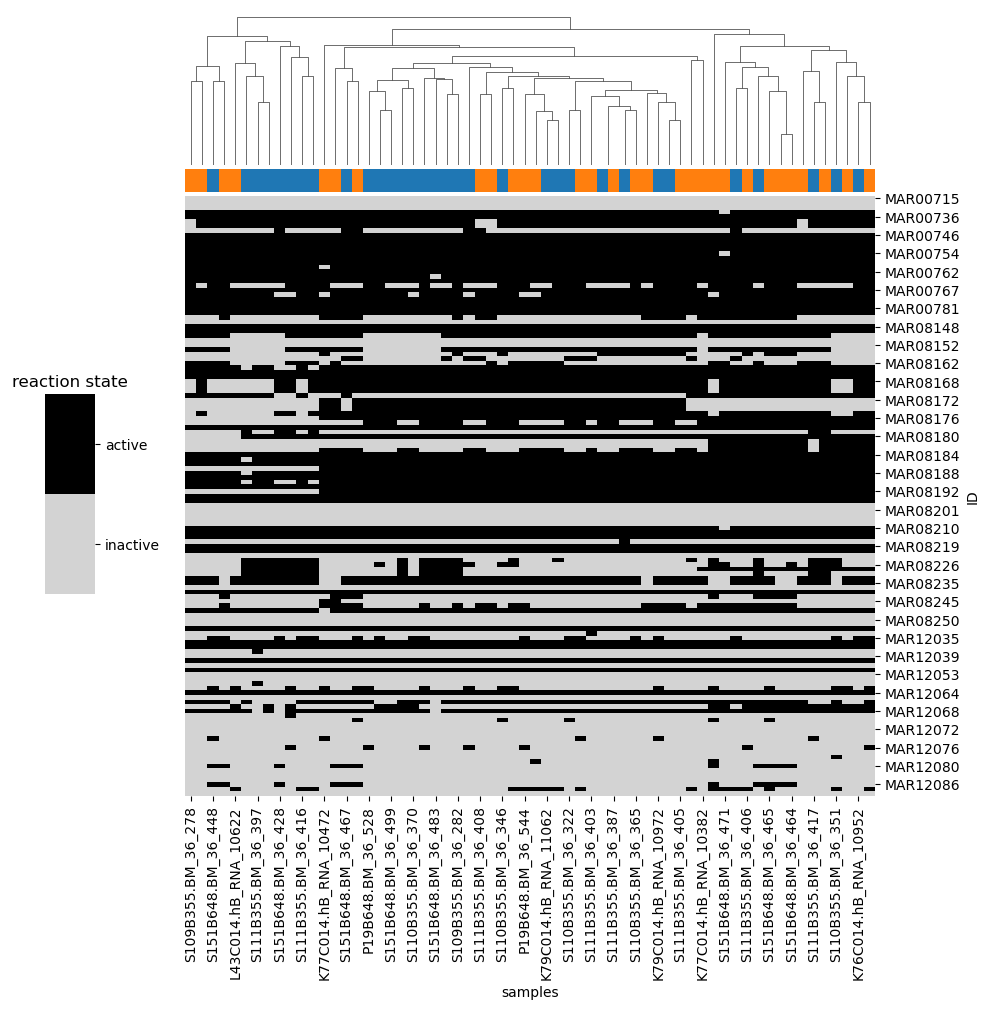

In [5]:
def my_clustermap(subsystems, ar=ar, gemsubsys=gemsubsys):
    l = [ar[k].loc[gemsubsys.loc[gemsubsys.isin(subsystems)].index] for k in ar.keys()]
    df = pd.concat(l, axis=1)
    coldict = {g: 'C' + str(i) for i, g in enumerate(ar.keys())}
    col_colors = list(itertools.chain(*[[v] * ar[k].shape[1] for k, v in coldict.items()]))
    cmap = ['lightgray', 'black']
    g = sns.clustermap(df, row_cluster=False, col_cluster=True, col_colors=col_colors, cmap=cmap)
    g.ax_heatmap.set_xlabel('samples')
    g.ax_cbar.set_position((0.05, 0.4, 0.05, 0.2))
    g.ax_cbar.set_title('reaction state')
    g.ax_cbar.set_yticks([0.25, 0.75])
    g.ax_cbar.set_yticklabels(['inactive', 'active'])
    return(g)

g = my_clustermap(['Sphingolipid metabolism'])

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


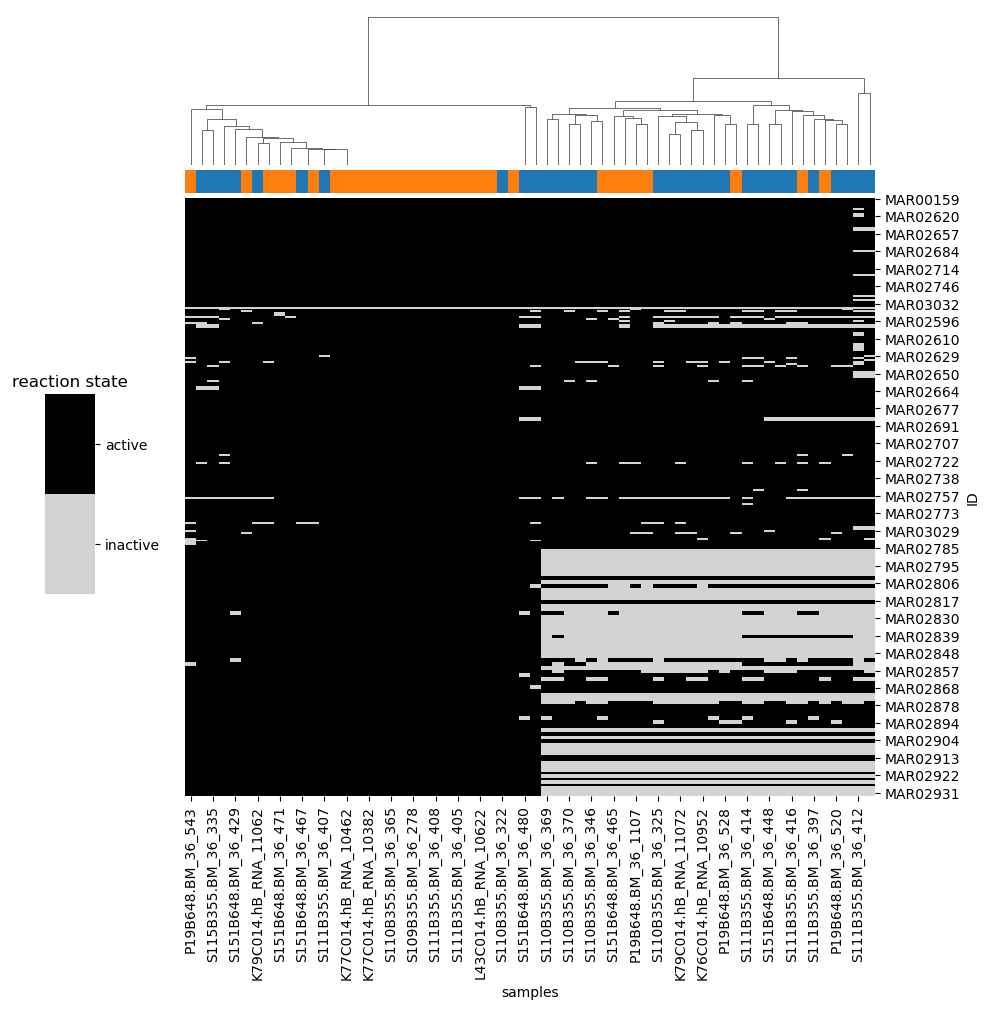

In [6]:
carnitine_subsystems = [
    'Carnitine shuttle (cytosolic)',
    'Carnitine shuttle (mitochondrial)',
    'Carnitine shuttle (peroxisomal)',
    'Carnitine shuttle (endoplasmic reticular)'
]

g = my_clustermap(carnitine_subsystems)
#g.fig.suptitle('Carnitine shuttle', y=1)

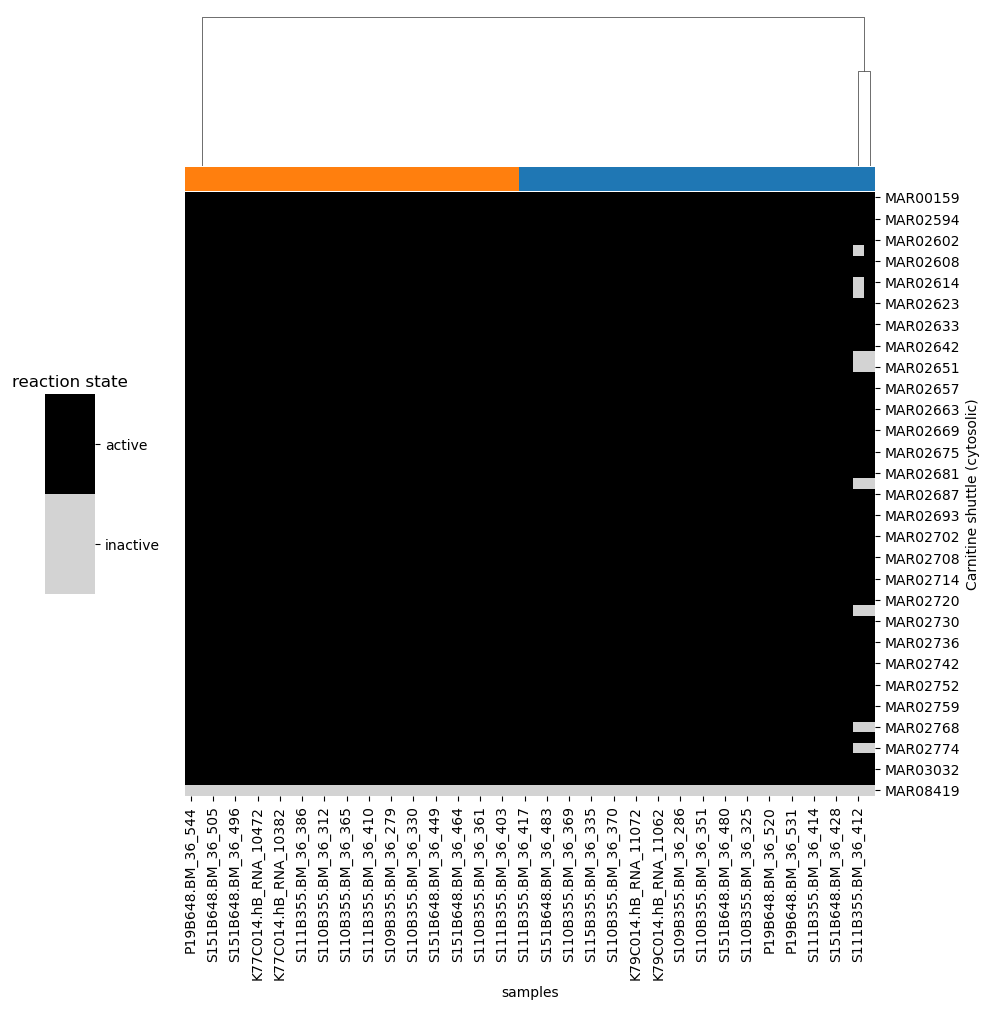

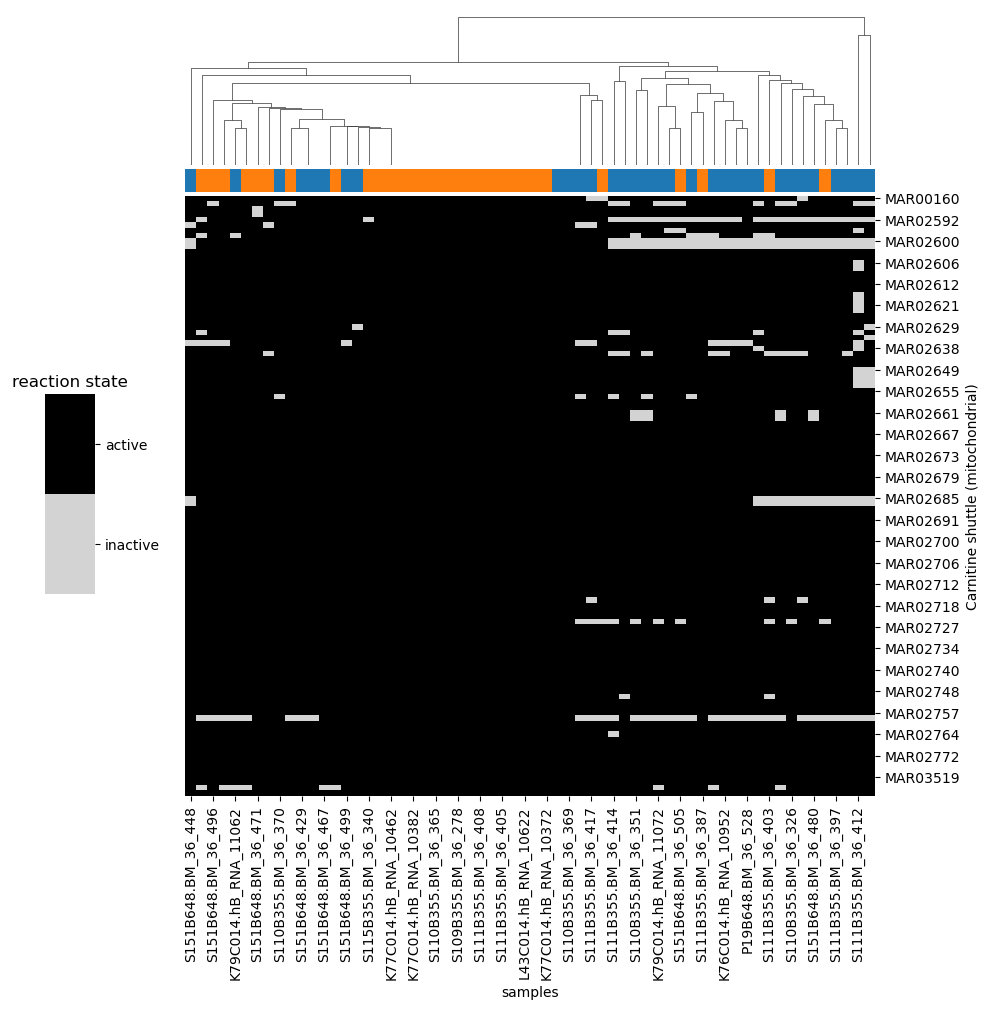

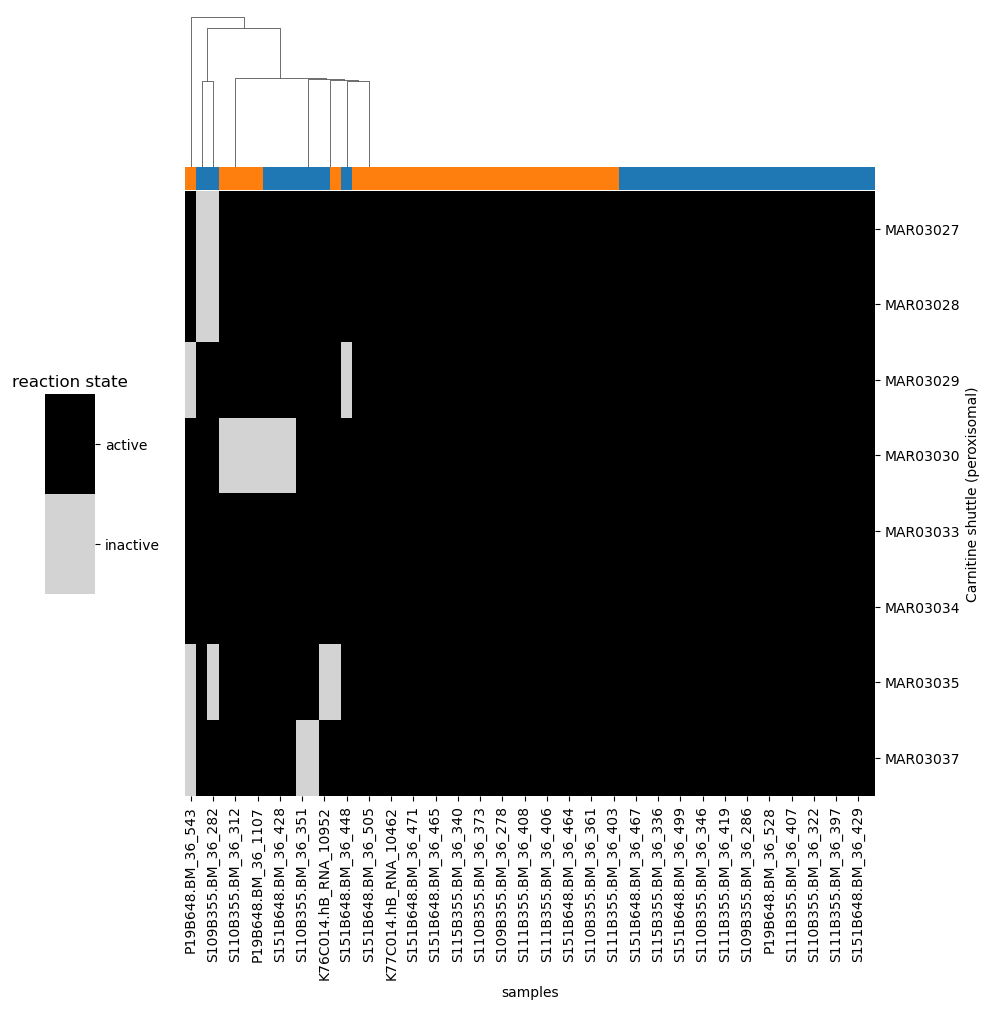

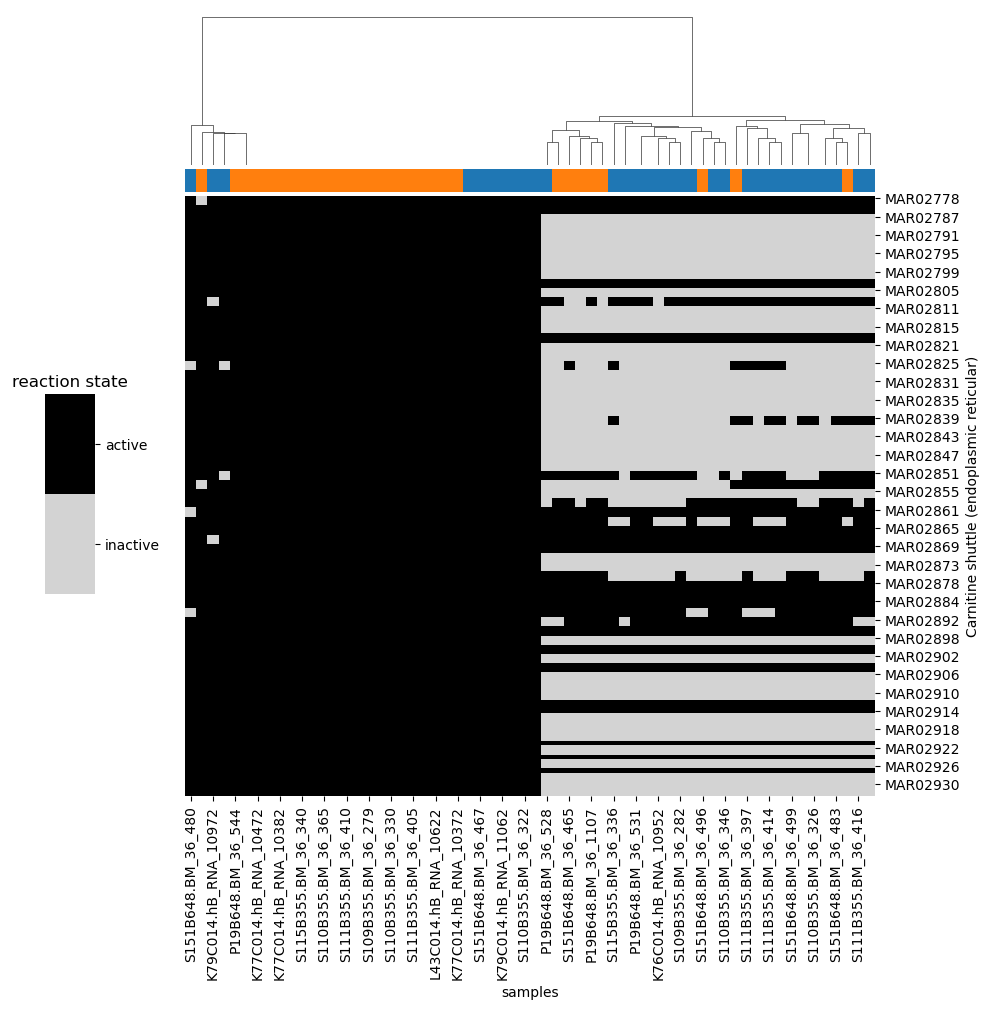

In [7]:
for subsys in carnitine_subsystems:
    g = my_clustermap([subsys])
    g.ax_heatmap.set_ylabel(subsys)

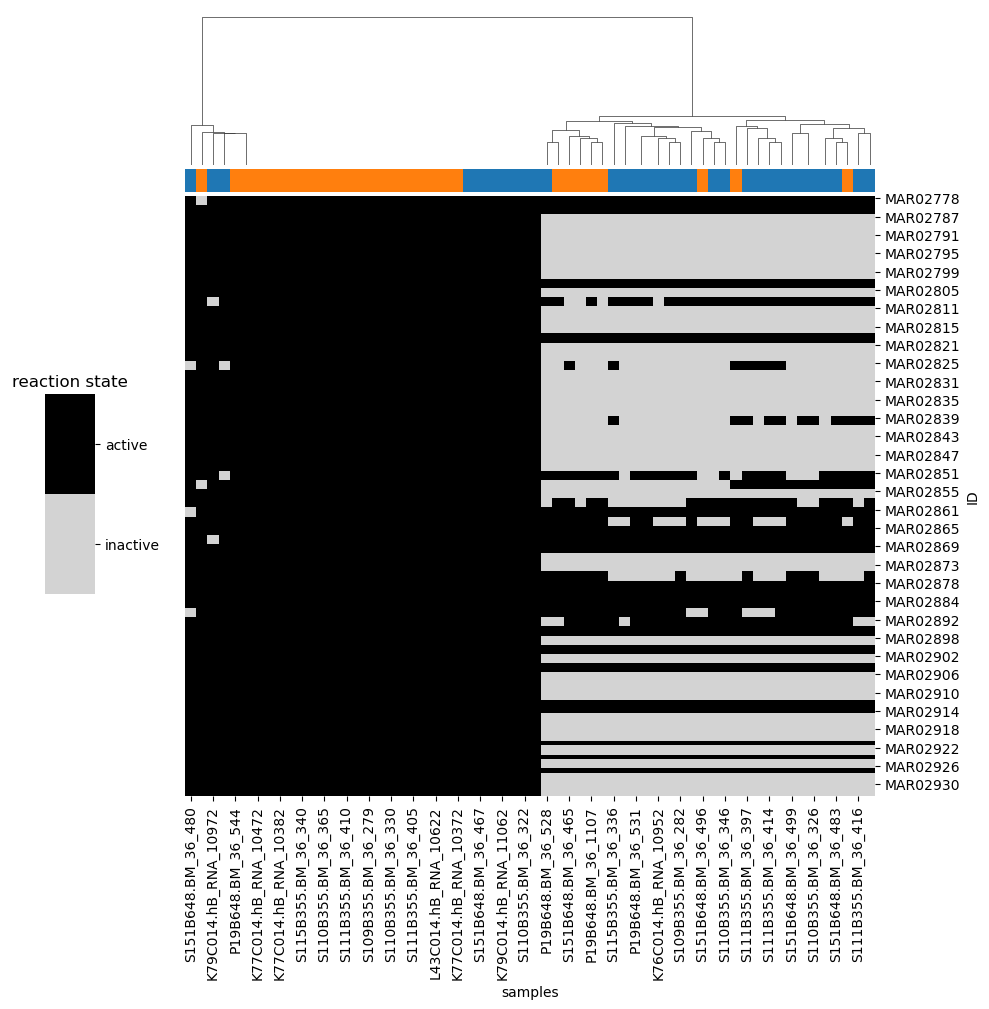

In [8]:
g = my_clustermap(['Carnitine shuttle (endoplasmic reticular)'])

In [9]:
def reshape2long(df, disease_state):
    long = df.stack().to_frame('rxn_state')
    long['rxn_state'] = np.int8(long.rxn_state)
    long['disease_state'] = disease_state
    long['rxn_ID'] = long.index.get_level_values(0)
    long['subject_ID'] = long.index.get_level_values(1)
    return(long)

def long_ar_subsys(subsystems, ar=ar, gemsubsys=gemsubsys):
    l = [reshape2long(ar[k].loc[gemsubsys.loc[gemsubsys.isin(subsystems)].index], k) for k in ar.keys()]
    long = pd.concat(l, axis=0)
    return(long)

In [25]:
#subsys = ['Carnitine shuttle (endoplasmic reticular)']
subsys = ['Carnitine shuttle (mitochondrial)']
data = long_ar_subsys(subsys, ar=ar, gemsubsys=gemsubsys)
#md = smf.mixedlm('rxn_state ~ disease_state', data, random=random)
md = smf.mixedlm('rxn_state ~ disease_state', data, groups=data['rxn_ID'])
res = md.fit()
res.summary()

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM      Dependent Variable:      rxn_state
No. Observations:      6944         Method:                  REML     
No. Groups:            112          Scale:                   0.0266   
Min. group size:       62           Log-Likelihood:          2571.4427
Max. group size:       62           Converged:               Yes      
Mean group size:       62.0                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.984    0.009 112.269 0.000  0.967  1.001
disease_state[T.m-control] -0.038    0.004  -9.795 0.000 -0.046 -0.031
Group Var                   0.008    0.007                            
======================================================================

"""

## Bayesian mixed effects logistic regression

Let $x=1$ encode an AD `disease_state`, and $x=0$ encode control.

The [inline documentation of the statsmodels.genmod.bayes_mixed_glm module](https://www.statsmodels.org/stable/_modules/statsmodels/genmod/bayes_mixed_glm.html) reveals that

* the error distribution $Y$ given the linear predictor $\eta$ is Bernoulli $Y \sim \mathrm{Binom}(n=1, p)$
* link function $g(\mu) = \mathrm{E}_b(\eta) = x\beta + Zb$ is logit:
\begin{equation}
\mathrm{E}_b(\eta) = \mathrm{E}_b(x\beta + Zb) = x\beta = \mathrm{logit}(\pi) = \mathrm{log}(\pi / (1 - \pi))
\end{equation}
    * The first equation follows from $\mathrm{E}_b(b) = 0$ since $b \sim N(0, G)$, i.e $b$ is normally distributed with mean 0
    * The second equation follows from $x\beta = \eta = g(\mu)$, where the link function $g = \mathrm{logit}$ and from $\mathrm{E}(Y \, |\, \eta) = \mu = \pi$, where $\pi$ is the expected proportion of active reactions ($Y=1$)
    * The last expression $\mathrm{log}(\pi / (1 - \pi))$ is the posterior log odds

Therefore
\begin{eqnarray}
x\beta &=& \mathrm{log} \frac{\pi(x)}{1 - \pi(x)} \\
\beta &=& \mathrm{log} \frac{\pi(x=1)}{1 - \pi(x=1)} \; \Leftrightarrow \; e^\beta = \frac{\pi(x=1)}{1 - \pi(x=1)}
\end{eqnarray}
which means that we can interpret $\beta$ as the posterior log odds ratio of reaction state for AD w.r.t control.  (Note that if $x=0 \Rightarrow 0\beta = 0 = \mathrm{log}(\pi(x=0) / (1 - \pi(x=0)))$, so that the second equation above follows from the first one.)


It follows that the log odds ratio

In [26]:
random = {'Reactions': 'rxn_ID', 'Subjects': 'subject_ID'}
formula = 'rxn_state ~ C(disease_state, levels=["m-control", "m-AD-B2"])'
prior_log_odds_sdev = 2
fe_p = 2
md = BinomialBayesMixedGLM.from_formula(formula, random, data, vcp_p=0.2, fe_p=prior_log_odds_sdev)
res = md.fit_vb()
res.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,1.9279,0.0847,,,
"C(disease_state, levels=[""m-control"", ""m-AD-B2""])[T.m-AD-B2]",M,2.3314,0.1692,,,
Reactions,V,0.8776,0.0584,2.405,2.140,2.703
Subjects,V,0.3265,0.0778,1.386,1.186,1.619


In [27]:
res_map = md.fit_map()
res_map.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,2.5724,1.1724,,,
"C(disease_state, levels=[""m-control"", ""m-AD-B2""])[T.m-AD-B2]",M,1.6460,0.2673,,,
Reactions,V,0.1922,0.0852,1.212,1.022,1.437
Subjects,V,-0.2851,0.1533,0.752,0.553,1.022


In [21]:
%connect_info

{
  "shell_port": 60991,
  "iopub_port": 60992,
  "stdin_port": 60993,
  "control_port": 60995,
  "hb_port": 60994,
  "ip": "127.0.0.1",
  "key": "aa8faf30-900188302f7cdd0b144bd544",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d77e2bbe-c99d-4632-b4b8-ca73f539c5a1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
